# Semester assignment

In [111]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec

#Setting new parameters for plotting
newParams = {'figure.figsize'  : (12, 6),  # Figure size
             'figure.dpi'      : 100,      # figure resolution
             'axes.titlesize'  : 20,       # fontsize of title
             'axes.labelsize'  : 11,       # fontsize of axes labels
             'axes.linewidth'  : 2,        # width of the figure box lines
             'lines.linewidth' : 1,        # width of the plotted lines
             'savefig.dpi'     : 200,      # resolution of a figured saved using plt.savefig(filename)
             'ytick.labelsize' : 11,       # fontsize of tick labels on y axis
             'xtick.labelsize' : 11,       # fontsize of tick labels on x axis
             'legend.fontsize' : 12,       # fontsize of labels in legend
             'legend.frameon'  : True,     # activate frame on lengend?
            }
plt.rcParams.update(newParams) # Set new plotting parameters

plt.style.use('default')

Boundary conditions:
\begin{equation}
    V(x = 0, y) = 0, \\
    V(x = L, y) = 0, \\
    V(x, y = 0) = 0, \\
    V(x, y = L) = V_0 (x)
\end{equation}

Solving Laplace equation ($\nabla^2 V = 0$) with these boundary condition gives:

\begin{align}
    V(x, y) =& \sum_{n=1}^{\infty} c_n \text{sinh}(n \pi \xi_y ) \text{sin}(n  \pi \xi_x),\\
    c_n =& \frac{2}{\text{sinh}(n \pi)} \int_0^1 \text{d} \xi_x V_0 (\xi_x L) \text{sin}(n \pi \xi_x),
\end{align}

where $\xi_x = x/L$ and $\xi_y = y/L$ are dimensionless variables.

## Finding $V(x, y)$

In [112]:
########################################################
### Defining functions for calculations and plotting ###
########################################################


def c_n(x, V_0, n):
    '''Returns the fourier coefficient nr. n
    INPUT: x - values along x-axis (1D or 2D array),
        V_0 - initial condition at at y=L (1D array), 
        n - fourier coefficient number (integer)
    OUTPUT: fourier coefficient n (float)
    '''
    dx = L/N
    integral = np.sum(V_0 * np.sin(n*np.pi*x), axis=1) * dx
    return 2 * integral / np.sinh(n*np.pi) 


def potential(x, y, V_0, n):
    '''Calculates the potential given by V_0(x).
    INPUT: x and y - positions to evaluate (meshgrids/2D arrays), 
        V_0 - initial condition at at y=L (1D array), 
        n - number of terms in the sum  (integer).
    OUTPUT: V - calculated potential (meshgrid/2D array)
    '''
    V = np.zeros_like(x)  #Initializing an NxN array for V
    norm_diff = np.empty(n)  #Initializing an array for the differences of the norms to evaluate convergence.
    for i in range(1, n):
        ci = c_n(x, V_0, i)  #Calculating the fourier coefficient.
        Vi = ci*np.sinh(i*np.pi*y)*np.sin(i*np.pi*x)  #Calculating term i in the sum of V
        prev_norm = np.linalg.norm(V) 
        V += Vi 
        norm_diff[i] = np.linalg.norm(V) - prev_norm  #Calculating the norm difference
    return V, norm_diff


def init_pot_1(x, m=1):
    '''Initial potential of y=L number 1.'''
    return np.sin(m*np.pi*x)


def init_pot_2(x):
    '''Initial potential of y=L number 2.'''
    return (1 - (x - 0.5)**4)


def init_pot_3(x):
    '''Initial potential of y=L number 3.'''
    return np.heaviside(x - L*0.5, 1)*np.heaviside(L*0.75 - x, 1)


def plot_potential(x, y, V, pot_num=None):
    '''Plotting a colormap of the potential V with the edge potentials on the corresponding side of the tube.'''
    # Creating meshgrids for the colormap
    xx, yy = np.meshgrid(x, y)
    
    # Plotting a colormap of the potential V(x, y) with the edge potentials on the corresponding side of the tube.
    fig = plt.figure("V(x,y) in infinite, square hollow tube", figsize=(12,7))

    #Creating a gridspec to place the potential plots in the correct way.
    gs = gridspec.GridSpec(10, 5, figure=fig)   

    # Plotting V(x,y=L) as a function of x, should be similar to V_0(x).
    plt.subplot(gs.new_subplotspec((1, 1), colspan=3, rowspan=2))  
    plt.plot(x, V[len(y)-1,:], label="V(x, y=L)")
    plt.ylabel("V(x, y=L)")

    # Plotting V(x=0,y) as a function of y flipped to match the colormap. Should be 0.
    plt.subplot(gs.new_subplotspec((3, 0), rowspan=5))   
    plt.plot(V[:,0], y, label="V(x = 0, y)")
    plt.ylabel(r"$\xi_y$", fontsize=14)
    plt.xlabel("V(x=0, y)")

    # Plotting a colormap of the potential
    ax = plt.subplot(gs.new_subplotspec((3, 1), colspan=3, rowspan=5))   
    ax.axes.get_xaxis().set_visible(False) 
    ax.axes.get_yaxis().set_visible(False) 

    # Set colour interpolation and colour map
    colorinterpolation = 50
    colourMap = plt.cm.jet 

    # Configure the contour
    im = plt.contourf(xx, yy, V, colorinterpolation, cmap=colourMap)

    # Plotting V(x=L,y) as a function of y, flipped to match the colormap. Should be 0. 
    plt.subplot(gs.new_subplotspec((3, 4), rowspan=5))   
    plt.plot(V[:,-1], y, label="V(x=L, y)")
    plt.xlim(-0.05, 0.05)
    plt.xlabel("V(x=L, y)")

    # Plotting V(x,y=0) as a function of x. Should be 0.
    plt.subplot(gs.new_subplotspec((8, 1), colspan=3, rowspan=2))   
    plt.plot(x, V[0,:], label="V(x, y=0)")
    plt.xlabel(r"$\xi_x$",fontsize=14)
    plt.ylabel(f"V(x, y=0)")

    fig.suptitle(f'V(x, y) with initial potential {pot_num}', fontsize=16)

    plt.tight_layout(pad=0.3, w_pad=0.3, h_pad=0.3)

    # Adding the colorbar on the right side of the entire plot.
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    cb = fig.colorbar(im, cax=cbar_ax)
    cb.set_label("V")

    # Saving the plot as .png and showing the result in the plot window.
    #plt.savefig(f"pot{pot_num}.pdf")
    plt.show()
    
    
def el_field(V):
    '''Calculating the electric field and absolute value of a potential V.
    INPUT: V - potential (2D array)
    OUTPUT: E - Electric field (array with two elements made up of 2D arrays)
        E_abs - Absolute square of the electric field (float)
    '''
    E = np.gradient(V)
    E_abs = np.sqrt(E[0]**2 + E[1]**2)*L/N
    return E, E_abs

In [113]:
###################################
### Setting starting parameters ###
###################################

start = 0
L = 1
N = 1000   #number of points in x and y
n = 80   #number of fourier terms

# Creating x and y axes with N values between 0 and L
x = np.linspace(0, L, N)
y = np.linspace(0, L, N)

# Creating meshgrids for colormap of the potential
xx, yy = np.meshgrid(x, y)



###############################################################
### Calculating potentials for different initial potentials ###
###############################################################

#Initial potential 1, sin(m*pi*x)
V_1, norm_diff_1 = potential(xx, yy, init_pot_1(x), n)

#Initial potential 2, V_0(x) = 1 - (x - 0.5)**4
V_2, norm_diff_2 = potential(xx, yy, init_pot_2(x), n)

#Initial potential 3, V_0(x) = theta(x-L/2) * theta(3L/4 - x)
V_3, norm_diff_3 = potential(xx, yy, init_pot_3(x), n)

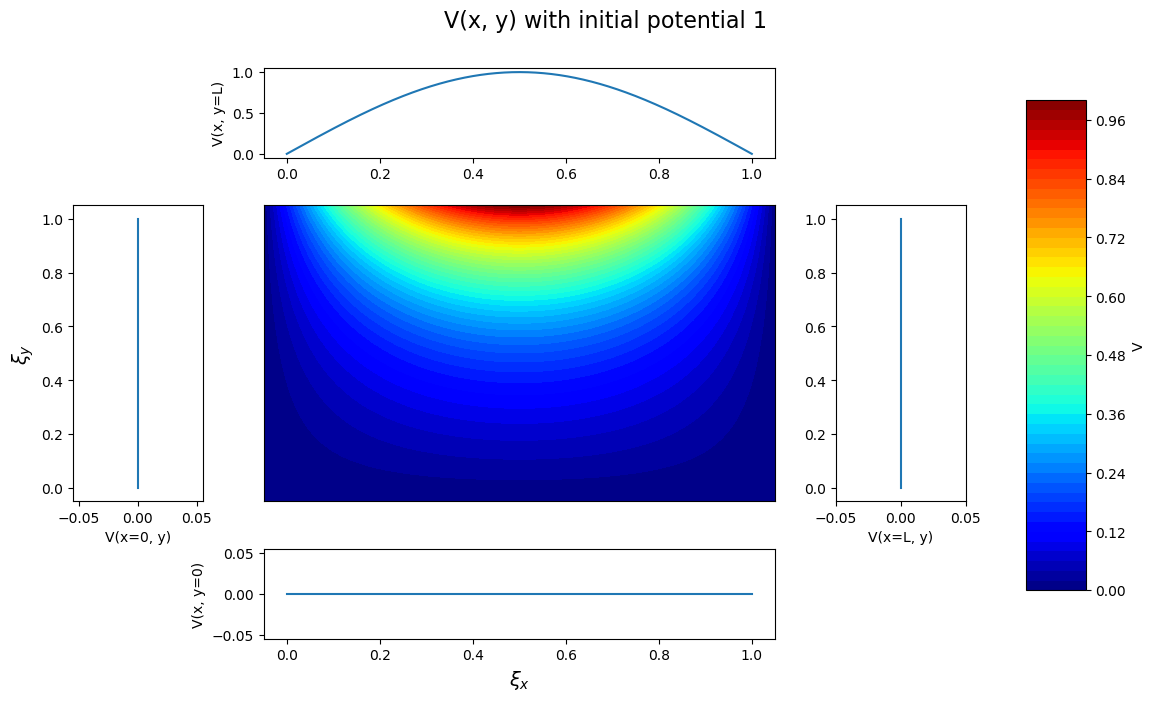

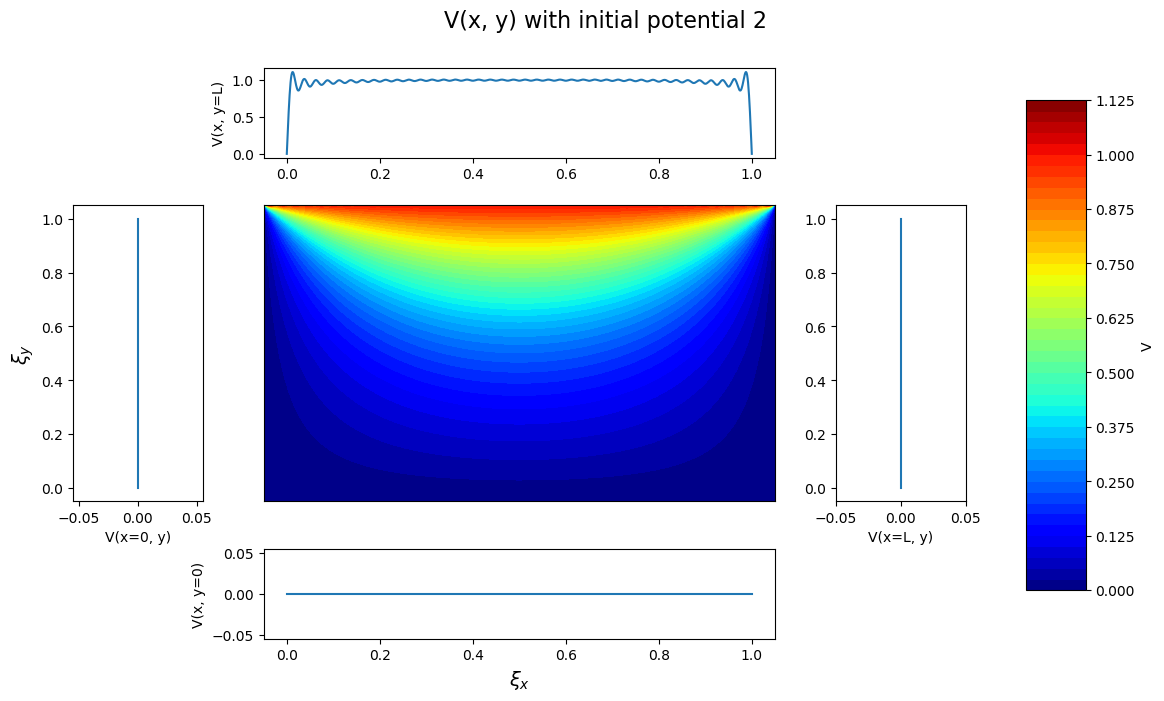

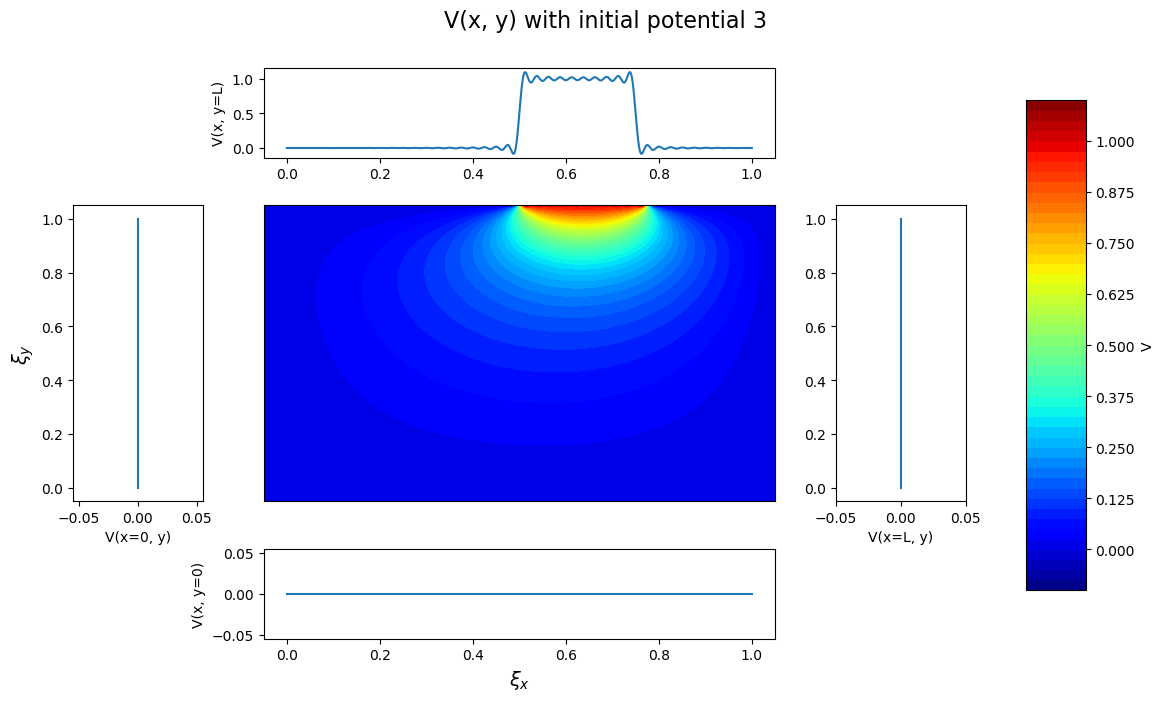

In [126]:
###############################
### Plotting the potentials ###
###############################  
    
plot_potential(x, y, V_1, 1)
plot_potential(x, y, V_2, 2)
plot_potential(x, y, V_3, 3)

## Convergence of $V(x, y)$

One way to investigate the rate of convergence for $V(x, y)$ is to look at the difference of the norm from one iteration to the next. Below, the differences are plotted as a function of the summation number n. 

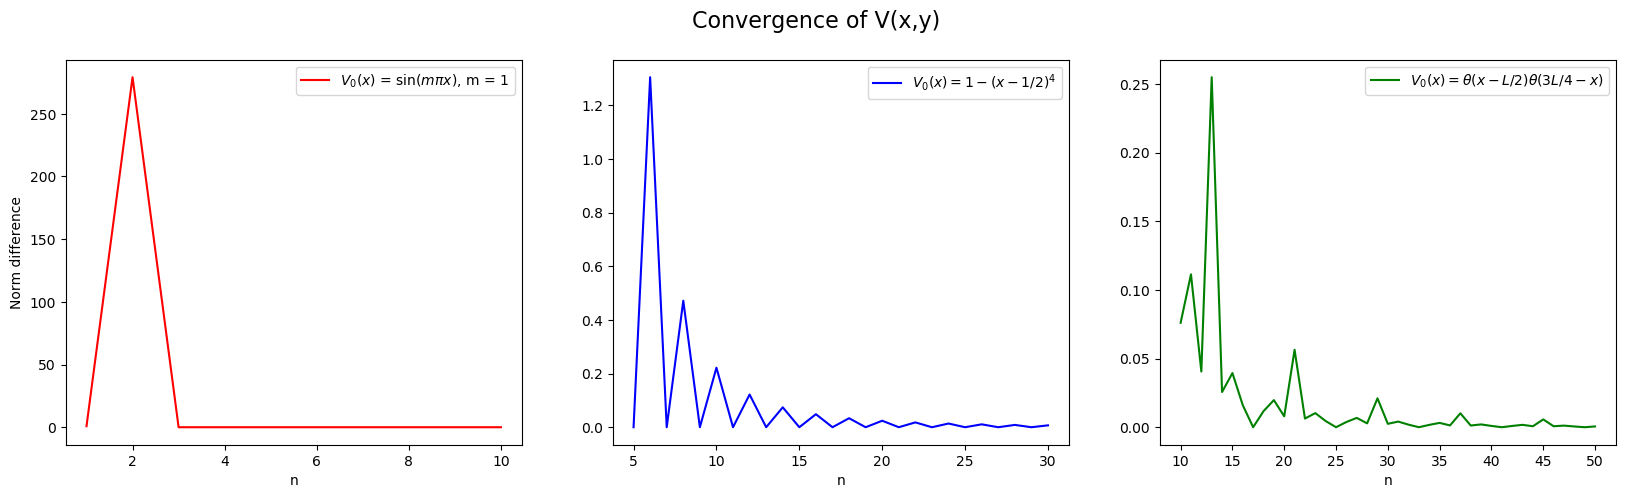

In [124]:
##############################################
### Plotting convergence of the potentials ###
##############################################

# Plotting the rate of convergence of V(x,y)
plt.figure("Convergence", figsize=(20, 5))
plt.suptitle("Convergence of V(x,y)", fontsize=16)

# Plotting the rate of convergence for initial potential 1: V_0(x) = sin(m*pi*x)
plt.subplot(131)
plt.plot(np.arange(1, 11), norm_diff_1[:10], "r-" ,label=r"$V_0(x)$ = sin($m \pi x$), m = 1")
plt.xlabel("n")
plt.ylabel("Norm difference")
plt.legend()

# Plotting the rate of convergence for initial potential 2: V_0(x) = V_0(x) = 1 - (x - 1/2)**4
plt.subplot(132)
n_start_2 = 5
n_end_2 = 30
plt.plot(np.arange(n_start_2, n_end_2+1), norm_diff_2[n_start_2-1:n_end_2], "b-", label=r"$V_0 (x) = 1 - (x - 1/2)^4$")
plt.xlabel("n")
plt.legend()

# Plotting the rate of convergence for initial potential 3: V_0(x) = theta(x-L/2)*theta(3L/4 - x)
plt.subplot(133)
n_start_3 = 10
n_end_3 = 50
plt.plot(np.arange(n_start_3, n_end_3+1), norm_diff_3[n_start_3-1:n_end_3], "g-", label=r"$V_0 (x) = \theta(x-L/2) \theta(3L/4 - x)$")
plt.xlabel("n")
plt.legend()

# Saving the figure as .png and showing the result.
#plt.savefig("convergence.png")
plt.show()

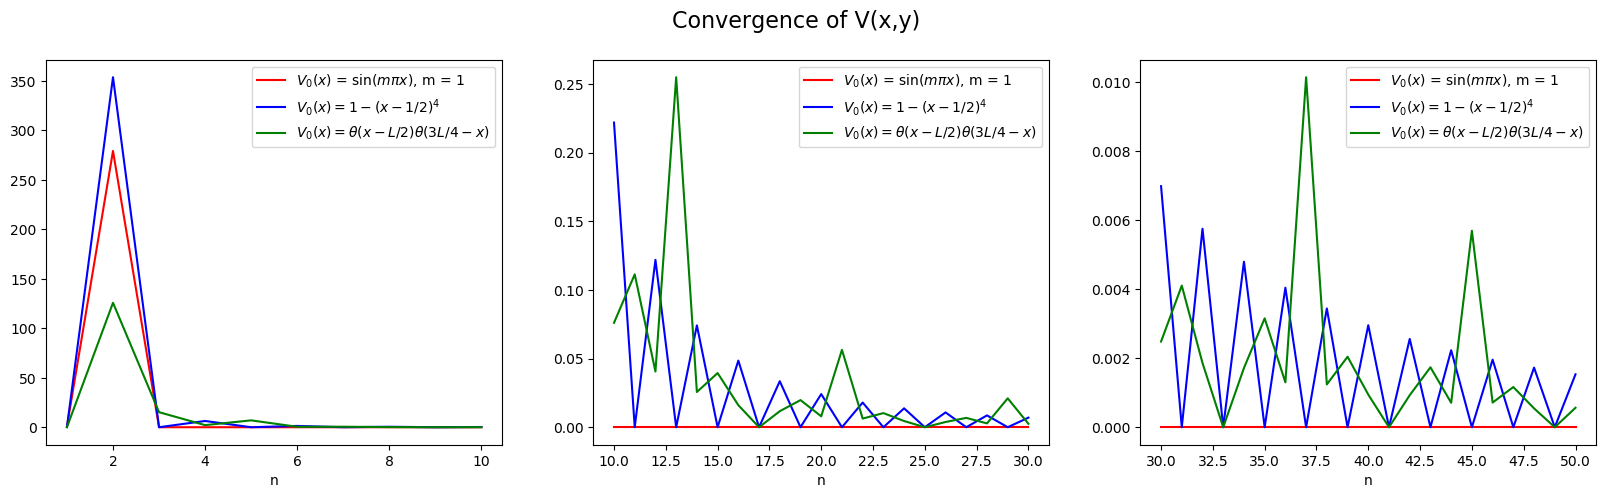

In [116]:
# Plotting the rate of convergence
plt.figure("Convergence", figsize=(20, 5))
plt.suptitle("Convergence of V(x,y)", fontsize=16)

end_1 = 10
end_2 = 30
end_3 = 50

plt.subplot(131)
plt.plot(np.arange(1, end_1+1), norm_diff_1[:end_1], "r-" ,label=r"$V_0(x)$ = sin($m \pi x$), m = 1")
plt.plot(np.arange(1, end_1+1), norm_diff_2[:end_1], "b-", label=r"$V_0 (x) = 1 - (x - 1/2)^4$")
plt.plot(np.arange(1, end_1+1), norm_diff_3[:end_1], "g-", label=r"$V_0 (x) = \theta(x-L/2) \theta(3L/4 - x)$")
plt.xlabel("n")
plt.legend()

plt.subplot(132)
plt.plot(np.arange(end_1, end_2+1), norm_diff_1[end_1-1:end_2], "r-" ,label=r"$V_0(x)$ = sin($m \pi x$), m = 1")
plt.plot(np.arange(end_1, end_2+1), norm_diff_2[end_1-1:end_2], "b-", label=r"$V_0 (x) = 1 - (x - 1/2)^4$")
plt.plot(np.arange(end_1, end_2+1), norm_diff_3[end_1-1:end_2], "g-", label=r"$V_0 (x) = \theta(x-L/2) \theta(3L/4 - x)$")
plt.xlabel("n")
plt.legend()

plt.subplot(133)
plt.plot(np.arange(end_2, end_3+1), norm_diff_1[end_2-1:end_3], "r-" ,label=r"$V_0(x)$ = sin($m \pi x$), m = 1")
plt.plot(np.arange(end_2, end_3+1), norm_diff_2[end_2-1:end_3], "b-", label=r"$V_0 (x) = 1 - (x - 1/2)^4$")
plt.plot(np.arange(end_2, end_3+1), norm_diff_3[end_2-1:end_3], "g-", label=r"$V_0 (x) = \theta(x-L/2) \theta(3L/4 - x)$")
plt.xlabel("n")
plt.legend()

plt.show()

## Finding $\bf{E}$$(x, y)$

To find the electric field, one takes the divergence of the potential,

\begin{equation}
    E = - \nabla V.
\end{equation}

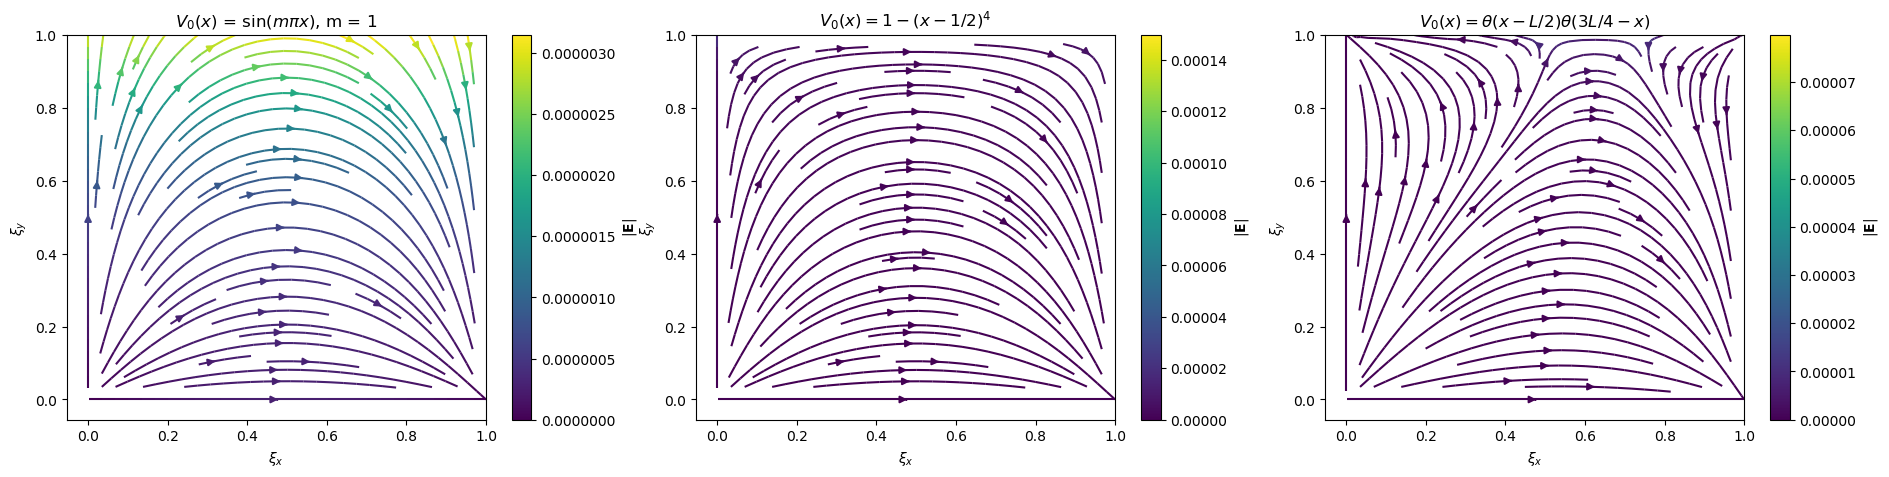

In [125]:
##################################
### Finding the electric field ###
##################################

#Calculating the electric field E from V, and |E|^2 to use as a color reference.
E_1, E_abs_1 = el_field(V_1)
E_2, E_abs_2 = el_field(V_2)
E_3, E_abs_3 = el_field(V_3)


# Plotting E as a streamplot.
plt.figure("Electric field", figsize=(23,5))
#plt.suptitle(r"$\bf{E}$(x, y)", fontsize=16)

# Plotting the electric field of V(x,y) with initial potential 1: V_0(x) = sin(m*pi*x)
plt.subplot(131)
plt.title(r"$V_0(x)$ = sin($m \pi x$), m = 1")
plt.streamplot(xx, yy, E_1[0], E_1[1], color=E_abs_1)
plt.xlabel(r"$\xi_x$")
plt.ylabel(r"$\xi_y$")
cb1 = plt.colorbar()
cb1.set_label(r"|$\bf{E}$|")

# Plotting the electric field of V(x,y) with initial potential 2: V_0(x) = V_0(x) = 1 - (x - 1/2)**4
plt.subplot(132)
plt.title(r"$V_0 (x) = 1 - (x - 1/2)^4$")
plt.streamplot(xx, yy, E_2[0], E_2[1], color=E_abs_2)
plt.xlabel(r"$\xi_x$")
plt.ylabel(r"$\xi_y$")
cb2 = plt.colorbar()
cb2.set_label(r"|$\bf{E}$|")

#  Plotting the electric field of V(x,y) with initial potential 3: V_0(x) = theta(x-L/2)*theta(3L/4 - x)
plt.subplot(133)
plt.title(r"$V_0 (x) = \theta(x-L/2) \theta(3L/4 - x)$")
plt.streamplot(xx, yy, E_3[0], E_3[1], color=E_abs_3)
plt.xlabel(r"$\xi_x$") #"\n"  r"$V_0 (x) = \theta(x-L/2) \theta(3L/4 - x)$")
plt.ylabel(r"$\xi_y$")
cb3 = plt.colorbar()
cb3.set_label(r"|$\bf{E}$|")

# Saving the plot as .png and showing the result in the plot window.
#plt.savefig("E_field.png")
plt.show()

(0, 1)

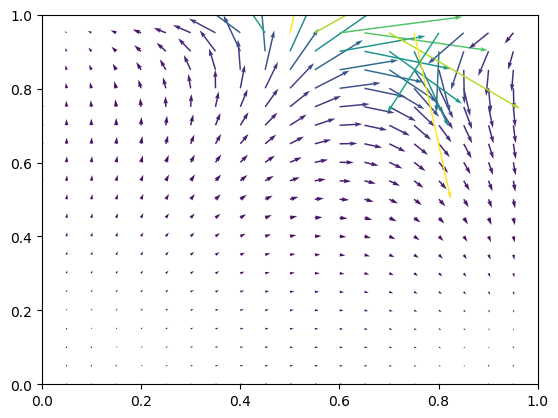

In [118]:
def samp(vec, sample=50):
    return vec[::sample, ::sample]

plt.quiver(samp(xx),
           samp(yy),
           samp(E[0]),
           samp(E[1]),
           samp(E_abs),
          )
plt.xlim(0, 1)
plt.ylim(0, 1)